In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

In [2]:
path_to_data = Path.cwd() / "resources" / "other_datasets_lesions_info.csv"
min_voxels = 50
min_slices = 2

In [3]:
df = pd.read_csv(path_to_data)

In [4]:
# Add column to identify the image
df["image"] = df.apply(
    lambda row: f"{'-'.join([row['dataset'], row['patient'], row['study'], row['filename']])}",
    axis=1
)

In [5]:
# Remove lesions smaller than 50 voxels or with 1 slice
df = df[
    (df["voxels_count"] >= min_voxels) |
    (df["slices_count"] >= min_slices)
].copy()

In [6]:
# Total annotated lesions
grouped = df.groupby('dataset').size().reset_index(name='lesions_count')
display(grouped)

,dataset,lesions_count
0,PET-CT,7141
1,Task03_Liver,857
2,Task06_Lung,70
3,Task07_Pancreas,283
4,Task08_HepaticVessel,532
5,Task10_Colon,130


In [7]:
# Total annotated volume
grouped = df.groupby('dataset')[['volume_mm3', 'volume_ml']].sum()
display(grouped)

,volume_mm3,volume_ml
dataset,,
PET-CT,1.100855e+08,110085.477634
Task03_Liver,1.021325e+07,10213.245204
Task06_Lung,1.384761e+06,1384.760864
Task07_Pancreas,3.635317e+06,3635.316687
Task08_HepaticVessel,4.225789e+07,42257.885540
Task10_Colon,4.540225e+06,4540.225030


In [8]:
# Volumes with annotated lesions
grouped = df.groupby(['dataset'])['image'].nunique().reset_index(name='annotated_volumes')
display(grouped)

,dataset,annotated_volumes
0,PET-CT,501
1,Task03_Liver,118
2,Task06_Lung,63
3,Task07_Pancreas,281
4,Task08_HepaticVessel,303
5,Task10_Colon,126


In [9]:
# Statistics of annotated lesions
grouped = df.groupby('dataset')['volume_ml'].describe()
display(grouped)

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
PET-CT,7141.0,15.415975,77.274389,0.024882,0.559846,1.542687,4.615619,2144.682651
Task03_Liver,857.0,11.917439,54.748762,0.000976,0.172187,0.608098,3.366875,968.636209
Task06_Lung,70.0,19.782298,49.800521,0.003798,1.536333,4.951139,12.497090,370.380830
Task07_Pancreas,283.0,12.845642,46.564436,0.201219,2.747302,5.755612,10.189377,732.388147
Task08_HepaticVessel,532.0,79.432116,244.763596,0.015877,1.028779,6.059212,40.031004,2122.625152
Task10_Colon,130.0,34.924808,50.488145,0.148924,11.412627,21.194216,39.414937,467.862643


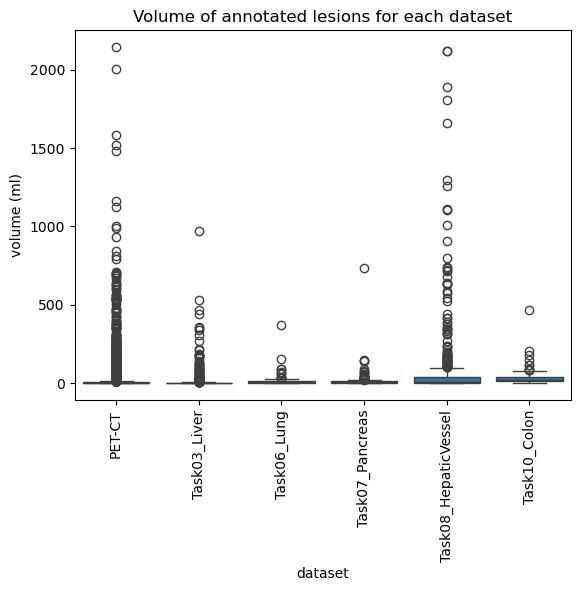

In [10]:
# Boxplots of lesion volumes
sns.boxplot(x="dataset", y="volume_ml", data=df)
plt.title("Volume of annotated lesions for each dataset")
plt.xticks(rotation=90)
plt.ylabel("volume (ml)")
plt.show()

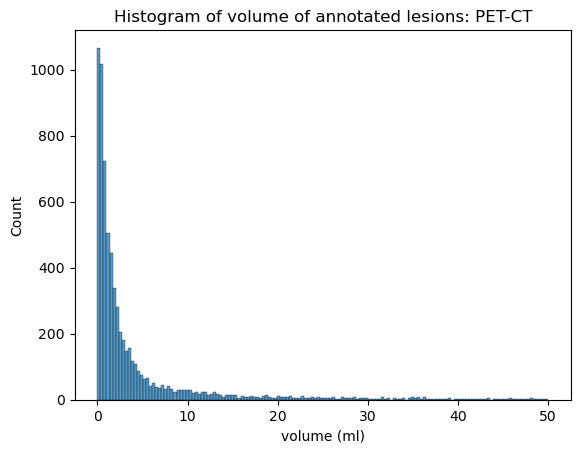

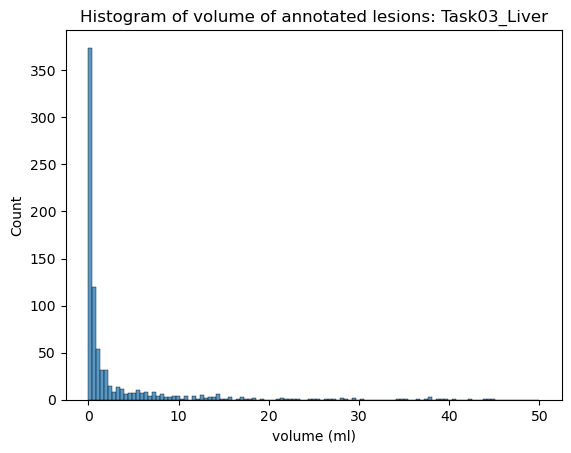

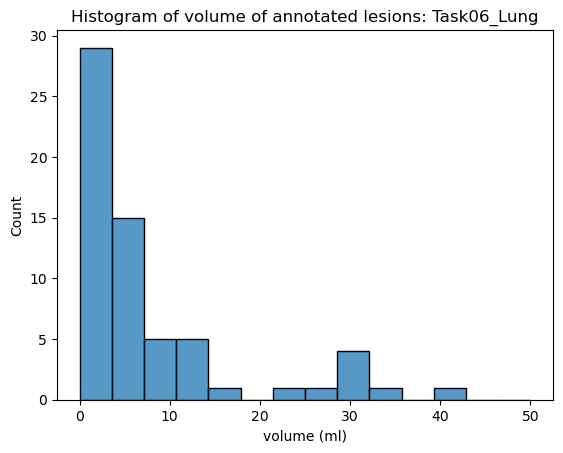

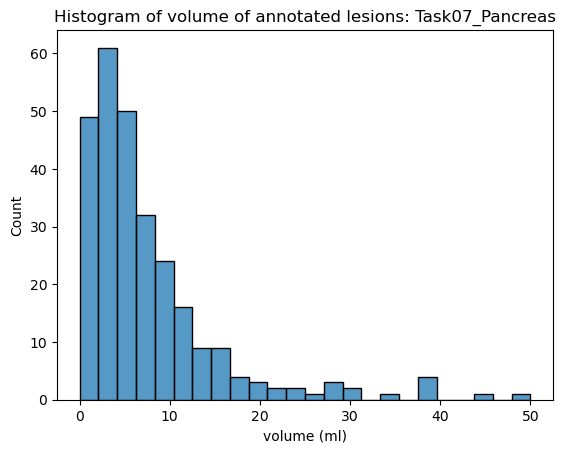

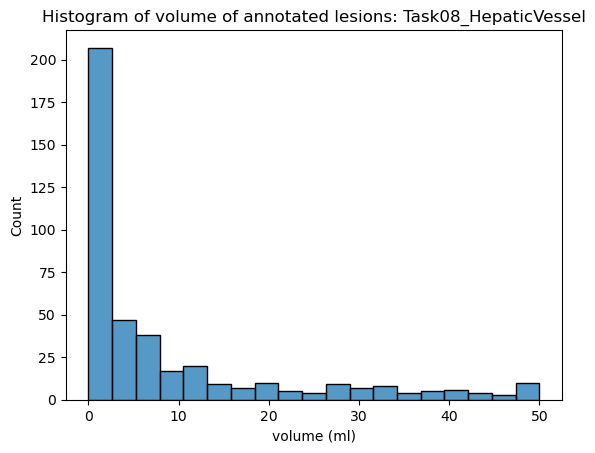

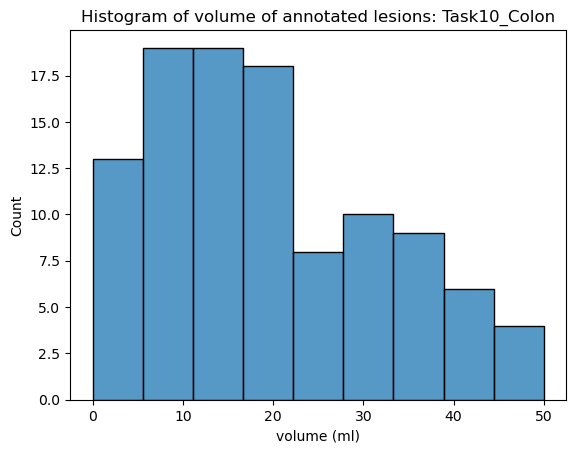

In [11]:
# Histograms of annotated lesions
warnings.filterwarnings("ignore", "use_inf_as_na")
for dataset in df['dataset'].unique().tolist():
    sns.histplot(
        df[df["dataset"] == dataset]["volume_ml"],
        binrange=(0,50)
    )
    plt.xlabel("volume (ml)")
    plt.title(f"Histogram of volume of annotated lesions: {dataset}")
    plt.show()